In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import copy

from picca.fitter2.control import fitter2
from picca import wedgize

## Initialize the fitter

In [2]:
chi2_file = 'fitter_only/chi2.ini'
fitter = fitter2(chi2_file)

INFO: reading input Pk /global/u1/a/acuceu/lib/picca/py/picca/fitter2/models/PlanckDR16/PlanckDR16.fits
INFO: reading /global/u1/a/acuceu/dev/fitter2_tutorial/fitter_only/standard_lya_lyaxlya_lya.ini
LOG: Full matrix is positive definite
LOG: Reduced matrix is positive definite


### If you want you can run the fitter straight from the notebook. However, this only works for single core options

In [3]:
fitter.run()

Calculating growth factor for Om = 0.314569514863487, OL = 0.685350734594958
------------------------------------------------------------------
| FCN = 2357                    |      Ncalls=20 (20 total)      |
| EDM = 1.3e-06 (Goal: 0.0002)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
|   | Name 

## Let's have a look at the structure of the fitter object

In [4]:
# data components are in a list: fitter.chi2.data
# e.g. in our case we only have one components - Lya(Lya)xLya(Lya):
data_0 = fitter.chi2.data[0]

# we can look at the best fit parameters 
best_fit = fitter.chi2.best_fit
print(best_fit.values)

# Get the fiducial power specturm
k = fitter.chi2.k
pk_full = fitter.chi2.pk_lin
pk_smooth = fitter.chi2.pksb_lin

<ValueView of Minuit at 555556c1bf40>
  alpha_LYA: 2.9
  ap: 1.027988603762357
  at: 1.002744893467143
  bao_amp: 1.0
  beta_LYA: 1.207455040252803
  bias_eta_LYA: -0.19566110718547458
  dnl_arinyo_av: 0.5378
  dnl_arinyo_bv: 1.607
  dnl_arinyo_kp: 19.47
  dnl_arinyo_kv: 1.11454
  dnl_arinyo_q1: 0.8558
  growth_rate: 0.970386193694752
  par binsize cf_z_0_10: 4.0
  per binsize cf_z_0_10: 4.0
  sigmaNL_par: 6.36984
  sigmaNL_per: 3.24


## Plot the measured correlation function

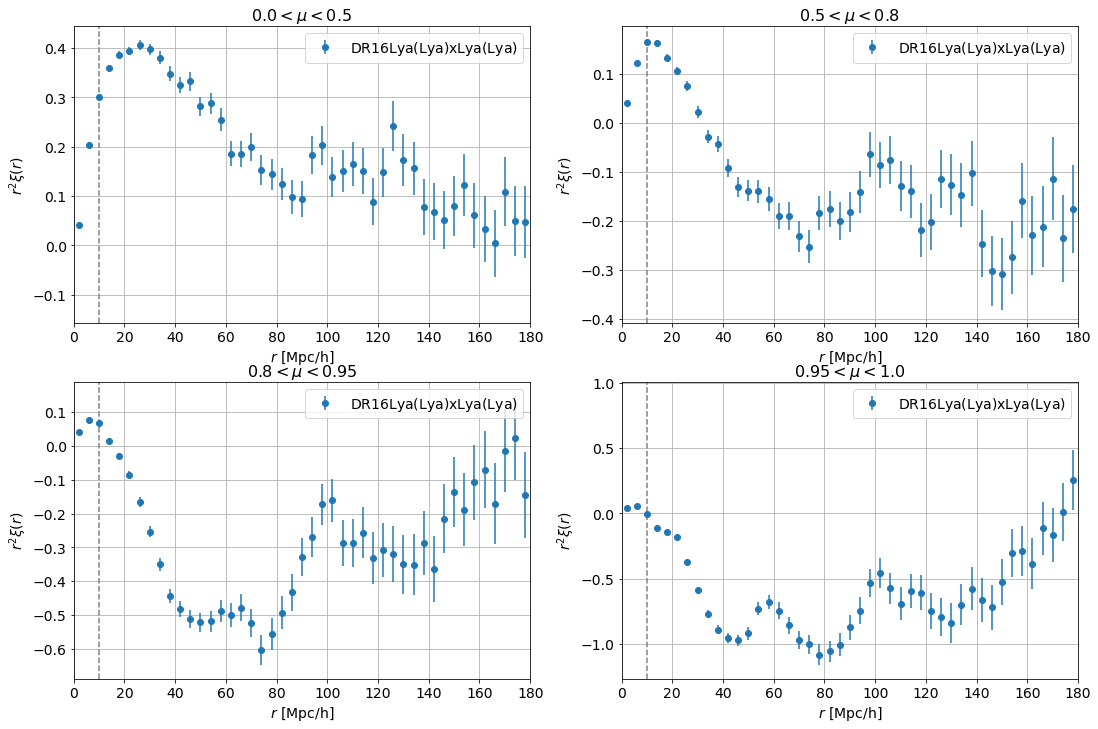

In [64]:
data = fitter.chi2.data[0].da
cov = fitter.chi2.data[0].co

plt.rcParams['figure.figsize'] = 18,12
plt.rcParams['font.size'] = 14
fig, axs = plt.subplots(2,2)

axs = np.array(axs).reshape(-1)
mus= [0., 0.5, 0.8, 0.95, 1.]
mu_zip = zip(mus[:-1],mus[1:])

for i, mu in enumerate(mu_zip):
    wedge_obj = wedgize.wedge(mumin=mu[0],mumax=mu[1],absoluteMu=True)

    r, d, d_cov = wedge_obj.wedge(data, cov)
    axs[i].errorbar(r, d*r**2,yerr=np.sqrt(d_cov.diagonal())*r**2,fmt="o",label=r'$\mathrm{DR16 Lya(Lya)xLya(Lya)}$')

    axs[i].set_ylabel(r"$r^2\xi(r)$")
    axs[i].set_xlabel(r"$r~[\mathrm{Mpc/h}]$")
    axs[i].set_title(r"${}<\mu<{}$".format(mu[0], mu[1]),fontsize=16)
    axs[i].set_xlim(0,180)
    axs[i].axvline(10, color='gray', ls='--')
    axs[i].legend()
    axs[i].grid()

## Define function to compute new xi model

In [65]:
def xi_model(data, pars, full_shape = False):
    pars['SB'] = False
    
    # Compute the peak component
    xi_peak = data.xi_model(k, pk_full-pk_smooth, pars)
    
    pars['SB'] = True & (not full_shape)
    sigmaNL_par = pars['sigmaNL_par']
    sigmaNL_per = pars['sigmaNL_per']
    pars['sigmaNL_par'] = 0.
    pars['sigmaNL_per'] = 0.
    
    # Compute the smooth component
    xi_sb = data.xi_model(k, pk_smooth, pars)
    
    pars['SB'] = False
    pars['sigmaNL_par'] = sigmaNL_par
    pars['sigmaNL_per'] = sigmaNL_per

    # Compute the full correlation
    xi_full = pars['bao_amp']*xi_peak + xi_sb
    
    return xi_full

In [66]:
pars = dict(best_fit.values)
best_model = xi_model(data_0, pars)
np.allclose(best_model, data_0.best_fit_model)

True

### Define function to make wedge plots

In [67]:
def plot_wedges(model_points, cov = data_0.co, multi_model = False, labels = None, data = None):
    plt.rcParams['figure.figsize'] = 18,12
    plt.rcParams['font.size'] = 14
    fig, axs = plt.subplots(2,2)

    axs = np.array(axs).reshape(-1)
    mus= [0., 0.5, 0.8, 0.95, 1.]
    mu_zip = zip(mus[:-1],mus[1:])

    for i, mu in enumerate(mu_zip):
        wedge_obj = wedgize.wedge(mumin=mu[0],mumax=mu[1],absoluteMu=True)
        
        if data is not None:
            r, d, d_cov = wedge_obj.wedge(data, cov)
            axs[i].errorbar(r, d*r**2,yerr=np.sqrt(d_cov.diagonal())*r**2,fmt="o",label=r'$\mathrm{DR16 Lya(Lya)xLya(Lya)}$')
        
        if multi_model:
            for model,label in zip(model_points,labels):
                r, f, _ = wedge_obj.wedge(model, cov)
                axs[i].plot(r, f*r**2, '-', label = label)
        else:
            r, f, _ = wedge_obj.wedge(model_points, cov)
            axs[i].plot(r, f*r**2, '-', label = 'Best Fit Model')
        
        axs[i].set_ylabel(r"$r^2\xi(r)$")
        axs[i].set_xlabel(r"$r~[\mathrm{Mpc/h}]$")
        axs[i].set_title(r"${}<\mu<{}$".format(mu[0], mu[1]),fontsize=16)
        axs[i].set_xlim(0,180)
        axs[i].axvline(10, color='gray', ls='--')
        axs[i].legend()
        axs[i].grid()

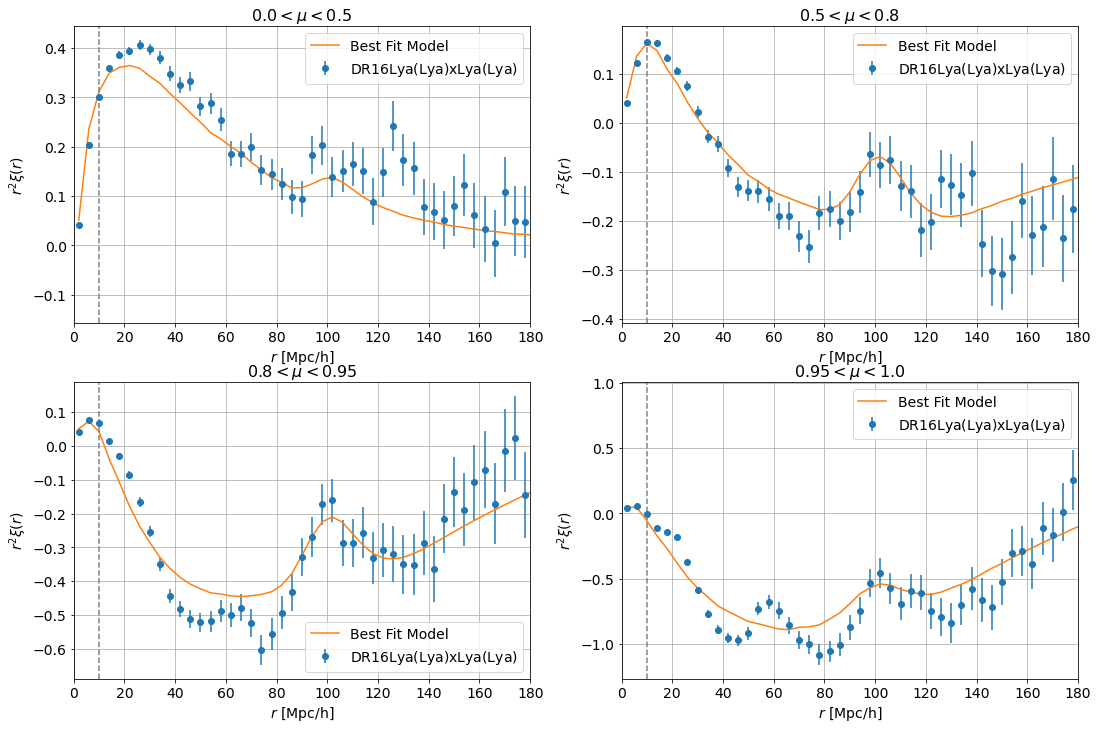

In [68]:
plot_wedges(best_model, data = data_0.da)

## Read the output files

In [11]:
# ff = h5py.File('fitter_only/output/fitter_only.h5', 'r')
ff_scan = h5py.File('fitter_only/output/fitter_scan.h5', 'r')
ff_fastmc = h5py.File('fitter_only/output/fitter_fastmc.h5', 'r')

### Have a look at the structure

In [54]:
print('Top Level:')
print(ff_scan.keys())
print('-------------------\n')

print('Best Fit:')
print(ff_scan['best fit'].attrs.keys())
print('-------------------\n')

print('Model:')
print(ff_scan['cf_z_0_10'].keys())
print('-------------------\n')

print('Fit:')
print(np.array(ff_scan['cf_z_0_10']['fit']))

Top Level:
<KeysViewHDF5 ['best fit', 'cf_z_0_10', 'chi2 scan']>
-------------------

Best Fit:
<KeysViewHDF5 ['alpha_LYA', 'ap', 'at', 'bao_amp', 'beta_LYA', 'bias_eta_LYA', 'cov[ap, ap]', 'cov[ap, at]', 'cov[ap, beta_LYA]', 'cov[ap, bias_eta_LYA]', 'cov[at, ap]', 'cov[at, at]', 'cov[at, beta_LYA]', 'cov[at, bias_eta_LYA]', 'cov[beta_LYA, ap]', 'cov[beta_LYA, at]', 'cov[beta_LYA, beta_LYA]', 'cov[beta_LYA, bias_eta_LYA]', 'cov[bias_eta_LYA, ap]', 'cov[bias_eta_LYA, at]', 'cov[bias_eta_LYA, beta_LYA]', 'cov[bias_eta_LYA, bias_eta_LYA]', 'dnl_arinyo_av', 'dnl_arinyo_bv', 'dnl_arinyo_kp', 'dnl_arinyo_kv', 'dnl_arinyo_q1', 'edm', 'fval', 'growth_rate', 'has_accurate_covar', 'has_covariance', 'has_made_posdef_covar', 'has_posdef_covar', 'has_reached_call_limit', 'has_valid_parameters', 'hesse_failed', 'is_above_max_edm', 'is_valid', 'list of fixed pars', 'list of free pars', 'ncalls', 'ndata', 'nfcn', 'npar', 'par binsize cf_z_0_10', 'per binsize cf_z_0_10', 'sigmaNL_par', 'sigmaNL_per', '

### Print the BAO parameters with their standard deviation and the $\chi^2$

In [33]:
for par in ['ap', 'at']:
    print('%s = %.3f +- %.3f' % (par, ff_scan['best fit'].attrs[par][0], ff_scan['best fit'].attrs[par][1]))
    
print('chi2 = %.2f' % ff_scan['best fit'].attrs['fval'])

ap = 1.028 +- 0.027
at = 1.003 +- 0.039
chi2 = 2241.74


### Scan results

In [39]:
print('Scan:')
print(ff_scan['chi2 scan'].keys())
print('-------------------\n')

print('Scan result:')
print(ff_scan['chi2 scan']['result'].attrs.keys())

Scan:
<KeysViewHDF5 ['ap', 'at', 'result']>
-------------------

Scan result:
<KeysViewHDF5 ['alpha_LYA', 'ap', 'at', 'bao_amp', 'beta_LYA', 'bias_eta_LYA', 'dnl_arinyo_av', 'dnl_arinyo_bv', 'dnl_arinyo_kp', 'dnl_arinyo_kv', 'dnl_arinyo_q1', 'fval', 'growth_rate', 'par binsize cf_z_0_10', 'per binsize cf_z_0_10', 'sigmaNL_par', 'sigmaNL_per']>


In [37]:
list(ff_scan['chi2 scan']['result']['values'])

[array([ 2.9000001e+00,  9.4999999e-01,  8.5000002e-01,  1.0000000e+00,
         1.2109149e+00, -1.9588497e-01,  5.3780001e-01,  1.6070000e+00,
         1.9469999e+01,  1.1145400e+00,  8.5579997e-01,  9.7038621e-01,
         4.0000000e+00,  4.0000000e+00,  6.3698401e+00,  3.2400000e+00,
         2.2716533e+03], dtype=float32),
 array([ 2.9000001e+00,  9.4999999e-01,  1.1500000e+00,  1.0000000e+00,
         1.2087637e+00, -1.9572249e-01,  5.3780001e-01,  1.6070000e+00,
         1.9469999e+01,  1.1145400e+00,  8.5579997e-01,  9.7038621e-01,
         4.0000000e+00,  4.0000000e+00,  6.3698401e+00,  3.2400000e+00,
         2.2540867e+03], dtype=float32),
 array([ 2.9000001e+00,  1.1500000e+00,  8.5000002e-01,  1.0000000e+00,
         1.2085263e+00, -1.9568130e-01,  5.3780001e-01,  1.6070000e+00,
         1.9469999e+01,  1.1145400e+00,  8.5579997e-01,  9.7038621e-01,
         4.0000000e+00,  4.0000000e+00,  6.3698401e+00,  3.2400000e+00,
         2.2648530e+03], dtype=float32),
 array([ 2.90

### FastMC results

In [51]:
print('FastMC:')
print(ff_fastmc['fast mc'].keys())
print('-------------------\n')

print('FastMC ap results:')
print('Values', list(ff_fastmc['fast mc']['ap']['values']))
print('Errors', list(ff_fastmc['fast mc']['ap']['errors']))
print('-------------------\n')

print('FastMC mock 0:')
print(np.array(ff_fastmc['fast mc']['cf_z_0_10_0']))

FastMC:
<KeysViewHDF5 ['alpha_LYA', 'ap', 'at', 'bao_amp', 'beta_LYA', 'bias_eta_LYA', 'cf_z_0_10_0', 'cf_z_0_10_1', 'cf_z_0_10_fiducial', 'chi2', 'dnl_arinyo_av', 'dnl_arinyo_bv', 'dnl_arinyo_kp', 'dnl_arinyo_kv', 'dnl_arinyo_q1', 'growth_rate', 'par binsize cf_z_0_10', 'per binsize cf_z_0_10', 'sigmaNL_par', 'sigmaNL_per']>
-------------------

FastMC ap results:
Values [1.0129619, 0.9874994]
Errors [0.031635273, 0.030586766]
-------------------

FastMC mock 0:
[ 1.2945823e-02  6.4726504e-03  3.4943707e-03 ... -2.7698593e-06
  5.2095406e-06 -2.7771723e-06]


In [55]:
ff_scan.close()
ff_fastmc.close()